In [2]:
# %% A) Setup + POBIERZ I ZAPISZ do CSV (miesięczne indeksy MS)

from __future__ import annotations
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import yfinance as yf

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# --- USTAWIENIA OGÓLNE ---
plt.rcParams["figure.dpi"] = 140
YEARS_BACK = 20

# KLUCZOWA POPRAWKA: wymuś tz-naive na START/END
END = pd.Timestamp.utcnow().tz_localize(None).floor("D")
START = (END - pd.DateOffset(years=YEARS_BACK)).tz_localize(None)

# (opcjonalny) fallback jeśli Yahoo nie działa: ścieżka do lokalnego CSV z cenami
PRICE_CSV_PATH = ""  # np. "data/soy_prices.csv"

# Sesja HTTP z nagłówkiem UA
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "soy-simple-model/1.0"})

# ====== UTIL: zdejmij strefę z indeksu ======
def _drop_tz_index(s: pd.Series | pd.DataFrame):
    if s is None:
        return s
    s = s.copy()
    if isinstance(s.index, pd.DatetimeIndex):
        if s.index.tz is not None:
            s.index = s.index.tz_localize(None)
    else:
        s.index = pd.to_datetime(s.index).tz_localize(None)
    return s

# ====== FUNKCJE DANYCH ======

# Bezpieczny downloader Yahoo → zawsze Series, indeks miesięczny (MS, tz-naive)
def fetch_yahoo_monthly(ticker: str, start: pd.Timestamp, end: pd.Timestamp) -> pd.Series:
    df = yf.download(
        ticker,
        start=start.date(),
        end=end.date(),
        auto_adjust=True,
        progress=False,
        interval="1mo",
        group_by="column",
        threads=True,
    )

    s = None
    if isinstance(df, pd.DataFrame) and not df.empty:
        if "Close" in df.columns:
            s = df["Close"]
        elif "Adj Close" in df.columns:
            s = df["Adj Close"]

    if s is None or (hasattr(s, "empty") and s.empty):
        df = yf.download(
            ticker,
            start=start.date(),
            end=end.date(),
            auto_adjust=True,
            progress=False,
            interval="1d",
            group_by="column",
            threads=True,
        )
        if isinstance(df, pd.DataFrame) and not df.empty:
            if "Close" in df.columns:
                s = df["Close"]
            elif "Adj Close" in df.columns:
                s = df["Adj Close"]
            if s is not None and not s.empty:
                s = s.copy()
                s.index = pd.to_datetime(s.index).tz_localize(None)
                s = s.resample("MS").mean()

    if isinstance(s, pd.DataFrame):
        s = s.iloc[:, 0] if s.shape[1] >= 1 else pd.Series(dtype=float)
    if s is None:
        s = pd.Series(dtype=float)

    if not s.empty:
        s = s.copy()
        s.index = pd.to_datetime(s.index).tz_localize(None)
        s.index = s.index.to_period("M").to_timestamp(how="start")
        s = s.sort_index().dropna()
    s.name = ticker
    return s

def load_price_from_csv(path: str) -> pd.Series:
    if not path or not os.path.exists(path):
        return pd.Series(dtype=float, name="SOY")
    dfp = pd.read_csv(path)
    date_col = next((c for c in dfp.columns if str(c).lower() in {"date","time","dt"}), None)
    price_col = next((c for c in dfp.columns if str(c).lower() in {"close","price","value"}), None)
    if date_col is None or price_col is None:
        raise ValueError("CSV musi zawierać kolumny daty (Date/Time/Dt) i ceny (Close/Price/Value).")
    s = pd.Series(dfp[price_col].values, index=pd.to_datetime(dfp[date_col]), name="SOY")
    s.index = s.index.tz_localize(None)
    return s.sort_index().resample("MS").mean().dropna().rename("SOY")

def fetch_oni_noaa() -> pd.Series:
    # próba 1: gotowy ONI
    try:
        url1 = "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
        r1 = SESSION.get(url1, timeout=30); r1.raise_for_status()
        rows = []
        for ln in r1.text.splitlines():
            p = ln.split()
            if len(p)==3 and p[0].isdigit() and p[1].isdigit():
                rows.append((int(p[0]), int(p[1]), float(p[2])))
        if rows:
            idx = pd.to_datetime([f"{y}-{m:02d}-01" for y,m,_ in rows]).tz_localize(None)
            return pd.Series([v for *_,v in rows], index=idx, name="ONI").sort_index()
    except Exception:
        pass
    # próba 2: NINO3.4 → 3M running mean
    try:
        url2 = "https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices"
        r2 = SESSION.get(url2, timeout=30); r2.raise_for_status()
        yrs, mons, n34 = [], [], []
        for ln in r2.text.splitlines():
            p = ln.split()
            if len(p)>=6 and p[0].isdigit() and p[1].isdigit():
                yrs.append(int(p[0])); mons.append(int(p[1])); n34.append(float(p[5]))
        if n34:
            idx = pd.to_datetime([f"{y}-{m:02d}-01" for y,m in zip(yrs,mons)]).tz_localize(None)
            s = pd.Series(n34, index=idx).sort_index()
            return s.rolling(3).mean().rename("ONI").dropna()
    except Exception:
        pass
    return pd.Series(dtype=float, name="ONI")

def fetch_openmeteo_point(lat: float, lon: float, start: pd.Timestamp, end: pd.Timestamp,
                          retries: int = 5, timeout: int = 30) -> pd.DataFrame:
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude": float(lat),
        "longitude": float(lon),
        "start_date": start.strftime("%Y-%m-%d"),
        "end_date": end.strftime("%Y-%m-%d"),
        "daily": "temperature_2m_mean,precipitation_sum",
        "timezone": "UTC",
    }
    last = None
    for a in range(retries):
        try:
            r = SESSION.get(url, params=params, timeout=timeout); r.raise_for_status()
            d = r.json()["daily"]
            idx = pd.to_datetime(d["time"]).tz_localize(None)
            return pd.DataFrame({"temp_c": d["temperature_2m_mean"], "precip_mm": d["precipitation_sum"]}, index=idx)
        except Exception as e:
            last = e
            time.sleep((1.2**a) + np.random.rand()*0.3)
    return pd.DataFrame(columns=["temp_c","precip_mm"])

# ====== INDEKS POGODOWY (0..100) ======
def _lin(x, x0, x1, y0, y1):
    return y0 + (y1-y0) * ((x-x0)/(x1-x0))

def soybean_temp_score(temp_c: pd.Series) -> pd.Series:
    t = pd.to_numeric(temp_c, errors="coerce")
    s = pd.Series(0.0, index=t.index)
    s[(t <= 5) | (t >= 40)] = 0
    m = (t > 5)  & (t <= 10); s[m] = _lin(t[m], 5, 10, 0, 30)
    m = (t > 10) & (t < 20);  s[m] = _lin(t[m], 10, 20, 30, 80)
    m = (t >= 20)& (t <= 30); s[m] = _lin(t[m], 20, 30, 80, 100)
    m = (t > 30) & (t < 37);  s[m] = _lin(t[m], 30, 37, 100, 50)
    m = (t >= 37)& (t < 40);  s[m] = _lin(t[m], 37, 40, 50, 0)
    return s.clip(0,100)

def soybean_precip_score_daily(precip_mm: pd.Series, window_days: int = 30) -> pd.Series:
    p30 = pd.to_numeric(precip_mm, errors="coerce").rolling(window_days, min_periods=int(window_days*0.7)).sum()
    s = pd.Series(0.0, index=p30.index)
    m = (p30 >= 60) & (p30 < 90);  s[m] = _lin(p30[m], 60, 90, 0, 100)
    m = (p30 >= 90) & (p30 <=150); s[m] = 100
    m = (p30 > 150) & (p30 <=220); s[m] = _lin(p30[m],150,220, 100, 0)
    return s.clip(0,100)

def soybean_weather_index(temp_c: pd.Series, precip_mm: pd.Series, w_temp=0.6, w_precip=0.4) -> pd.Series:
    temp_c, precip_mm = temp_c.align(precip_mm, join="inner")
    ts = soybean_temp_score(temp_c)
    ps = soybean_precip_score_daily(precip_mm)
    return (w_temp*ts + w_precip*ps).clip(0,100)

def monthly_weather_index_for_point(lat: float, lon: float, start: pd.Timestamp, end: pd.Timestamp) -> pd.Series:
    df = fetch_openmeteo_point(lat, lon, start, end)
    if df.empty:
        return pd.Series(dtype=float)
    idx_daily = soybean_weather_index(df["temp_c"], df["precip_mm"])
    s = idx_daily.resample("MS").mean().dropna()
    return _drop_tz_index(s)

# ====== POBIERZ I ZAPISZ DO CSV ======
OUT_DIR = "data"
OUT_CSV = os.path.join(OUT_DIR, "soy_simple_monthly.csv")
USA_LATLON = (41.5868, -93.6250)   # Des Moines, Iowa (Corn Belt)
BRA_LATLON = (-12.9833, -57.9300)  # środkowy Mato Grosso (soja BR)

os.makedirs(OUT_DIR, exist_ok=True)

WX_US = monthly_weather_index_for_point(*USA_LATLON, START, END).rename("WX_US")
WX_BR = monthly_weather_index_for_point(*BRA_LATLON, START, END).rename("WX_BR")

ONI = fetch_oni_noaa().rename("ONI")
ONI = _drop_tz_index(ONI)
ONI = ONI[(ONI.index >= START) & (ONI.index <= END)]

SOY = fetch_yahoo_monthly("ZS=F", START, END).rename("SOY")
SOY = _drop_tz_index(SOY)
if (SOY is None) or SOY.dropna().empty:
    SOY = _drop_tz_index(load_price_from_csv(PRICE_CSV_PATH).rename("SOY"))

# ALIGN → miesięcznie (MS), wszystko tz-naive
for s in (SOY, WX_US, WX_BR, ONI):
    s.index = pd.to_datetime(s.index).tz_localize(None)

df_raw = pd.concat([SOY, WX_US, WX_BR, ONI], axis=1).sort_index()
df_raw.index = df_raw.index.to_period("M").to_timestamp(how="start")
df_raw = df_raw.resample("MS").mean().dropna(how="all")

df_raw.to_csv(OUT_CSV, index_label="date")
print(f"Zapisano {len(df_raw)} wierszy → {OUT_CSV}")
display(df_raw.tail(6))


Zapisano 241 wierszy → data\soy_simple_monthly.csv


,SOY,WX_US,WX_BR,ONI
2025-03-01,1014.75,28.424516,62.011797,0.146667
2025-04-01,1034.75,44.934222,82.913333,0.196667
2025-05-01,1041.75,76.893548,76.306267,0.100000
2025-06-01,NaN,87.296159,52.374000,-0.073333
2025-07-01,961.75,78.663963,51.499355,-0.050000
2025-08-01,1042.50,79.503866,47.223529,NaN


In [ ]:
# %% A) Setup + POBIERZ I ZAPISZ do CSV (miesięczne indeksy MS)

from __future__ import annotations
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import yfinance as yf

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# --- USTAWIENIA OGÓLNE ---
plt.rcParams["figure.dpi"] = 140
YEARS_BACK = 20

# KLUCZOWA POPRAWKA: wymuś tz-naive na START/END
END = pd.Timestamp.utcnow().tz_localize(None).floor("D")
START = (END - pd.DateOffset(years=YEARS_BACK)).tz_localize(None)

# (opcjonalny) fallback jeśli Yahoo nie działa: ścieżka do lokalnego CSV z cenami
PRICE_CSV_PATH = ""  # np. "data/soy_prices.csv"

# Sesja HTTP z nagłówkiem UA
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "soy-simple-model/1.0"})

# ====== UTIL: zdejmij strefę z indeksu ======
def _drop_tz_index(s: pd.Series | pd.DataFrame):
    if s is None:
        return s
    s = s.copy()
    if isinstance(s.index, pd.DatetimeIndex):
        if s.index.tz is not None:
            s.index = s.index.tz_localize(None)
    else:
        s.index = pd.to_datetime(s.index).tz_localize(None)
    return s

# ====== FUNKCJE DANYCH ======

# Bezpieczny downloader Yahoo → zawsze Series, indeks miesięczny (MS, tz-naive)
def fetch_yahoo_monthly(ticker: str, start: pd.Timestamp, end: pd.Timestamp) -> pd.Series:
    df = yf.download(
        ticker,
        start=start.date(),
        end=end.date(),
        auto_adjust=True,
        progress=False,
        interval="1mo",
        group_by="column",
        threads=True,
    )

    s = None
    if isinstance(df, pd.DataFrame) and not df.empty:
        if "Close" in df.columns:
            s = df["Close"]
        elif "Adj Close" in df.columns:
            s = df["Adj Close"]

    if s is None or (hasattr(s, "empty") and s.empty):
        df = yf.download(
            ticker,
            start=start.date(),
            end=end.date(),
            auto_adjust=True,
            progress=False,
            interval="1d",
            group_by="column",
            threads=True,
        )
        if isinstance(df, pd.DataFrame) and not df.empty:
            if "Close" in df.columns:
                s = df["Close"]
            elif "Adj Close" in df.columns:
                s = df["Adj Close"]
            if s is not None and not s.empty:
                s = s.copy()
                s.index = pd.to_datetime(s.index).tz_localize(None)
                s = s.resample("MS").mean()

    if isinstance(s, pd.DataFrame):
        s = s.iloc[:, 0] if s.shape[1] >= 1 else pd.Series(dtype=float)
    if s is None:
        s = pd.Series(dtype=float)

    if not s.empty:
        s = s.copy()
        s.index = pd.to_datetime(s.index).tz_localize(None)
        s.index = s.index.to_period("M").to_timestamp(how="start")
        s = s.sort_index().dropna()
    s.name = ticker
    return s

def load_price_from_csv(path: str) -> pd.Series:
    if not path or not os.path.exists(path):
        return pd.Series(dtype=float, name="SOY")
    dfp = pd.read_csv(path)
    date_col = next((c for c in dfp.columns if str(c).lower() in {"date","time","dt"}), None)
    price_col = next((c for c in dfp.columns if str(c).lower() in {"close","price","value"}), None)
    if date_col is None or price_col is None:
        raise ValueError("CSV musi zawierać kolumny daty (Date/Time/Dt) i ceny (Close/Price/Value).")
    s = pd.Series(dfp[price_col].values, index=pd.to_datetime(dfp[date_col]), name="SOY")
    s.index = s.index.tz_localize(None)
    return s.sort_index().resample("MS").mean().dropna().rename("SOY")

def fetch_oni_noaa() -> pd.Series:
    # próba 1: gotowy ONI
    try:
        url1 = "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
        r1 = SESSION.get(url1, timeout=30); r1.raise_for_status()
        rows = []
        for ln in r1.text.splitlines():
            p = ln.split()
            if len(p)==3 and p[0].isdigit() and p[1].isdigit():
                rows.append((int(p[0]), int(p[1]), float(p[2])))
        if rows:
            idx = pd.to_datetime([f"{y}-{m:02d}-01" for y,m,_ in rows]).tz_localize(None)
            return pd.Series([v for *_,v in rows], index=idx, name="ONI").sort_index()
    except Exception:
        pass
    # próba 2: NINO3.4 → 3M running mean
    try:
        url2 = "https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices"
        r2 = SESSION.get(url2, timeout=30); r2.raise_for_status()
        yrs, mons, n34 = [], [], []
        for ln in r2.text.splitlines():
            p = ln.split()
            if len(p)>=6 and p[0].isdigit() and p[1].isdigit():
                yrs.append(int(p[0])); mons.append(int(p[1])); n34.append(float(p[5]))
        if n34:
            idx = pd.to_datetime([f"{y}-{m:02d}-01" for y,m in zip(yrs,mons)]).tz_localize(None)
            s = pd.Series(n34, index=idx).sort_index()
            return s.rolling(3).mean().rename("ONI").dropna()
    except Exception:
        pass
    return pd.Series(dtype=float, name="ONI")

def fetch_openmeteo_point(lat: float, lon: float, start: pd.Timestamp, end: pd.Timestamp,
                          retries: int = 5, timeout: int = 30) -> pd.DataFrame:
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude": float(lat),
        "longitude": float(lon),
        "start_date": start.strftime("%Y-%m-%d"),
        "end_date": end.strftime("%Y-%m-%d"),
        "daily": "temperature_2m_mean,precipitation_sum",
        "timezone": "UTC",
    }
    last = None
    for a in range(retries):
        try:
            r = SESSION.get(url, params=params, timeout=timeout); r.raise_for_status()
            d = r.json()["daily"]
            idx = pd.to_datetime(d["time"]).tz_localize(None)
            return pd.DataFrame({"temp_c": d["temperature_2m_mean"], "precip_mm": d["precipitation_sum"]}, index=idx)
        except Exception as e:
            last = e
            time.sleep((1.2**a) + np.random.rand()*0.3)
    return pd.DataFrame(columns=["temp_c","precip_mm"])

# ====== INDEKS POGODOWY (0..100) ======
def _lin(x, x0, x1, y0, y1):
    return y0 + (y1-y0) * ((x-x0)/(x1-x0))

def soybean_temp_score(temp_c: pd.Series) -> pd.Series:
    t = pd.to_numeric(temp_c, errors="coerce")
    s = pd.Series(0.0, index=t.index)
    s[(t <= 5) | (t >= 40)] = 0
    m = (t > 5)  & (t <= 10); s[m] = _lin(t[m], 5, 10, 0, 30)
    m = (t > 10) & (t < 20);  s[m] = _lin(t[m], 10, 20, 30, 80)
    m = (t >= 20)& (t <= 30); s[m] = _lin(t[m], 20, 30, 80, 100)
    m = (t > 30) & (t < 37);  s[m] = _lin(t[m], 30, 37, 100, 50)
    m = (t >= 37)& (t < 40);  s[m] = _lin(t[m], 37, 40, 50, 0)
    return s.clip(0,100)

def soybean_precip_score_daily(precip_mm: pd.Series, window_days: int = 30) -> pd.Series:
    p30 = pd.to_numeric(precip_mm, errors="coerce").rolling(window_days, min_periods=int(window_days*0.7)).sum()
    s = pd.Series(0.0, index=p30.index)
    m = (p30 >= 60) & (p30 < 90);  s[m] = _lin(p30[m], 60, 90, 0, 100)
    m = (p30 >= 90) & (p30 <=150); s[m] = 100
    m = (p30 > 150) & (p30 <=220); s[m] = _lin(p30[m],150,220, 100, 0)
    return s.clip(0,100)

def soybean_weather_index(temp_c: pd.Series, precip_mm: pd.Series, w_temp=0.6, w_precip=0.4) -> pd.Series:
    temp_c, precip_mm = temp_c.align(precip_mm, join="inner")
    ts = soybean_temp_score(temp_c)
    ps = soybean_precip_score_daily(precip_mm)
    return (w_temp*ts + w_precip*ps).clip(0,100)

def monthly_weather_index_for_point(lat: float, lon: float, start: pd.Timestamp, end: pd.Timestamp) -> pd.Series:
    df = fetch_openmeteo_point(lat, lon, start, end)
    if df.empty:
        return pd.Series(dtype=float)
    idx_daily = soybean_weather_index(df["temp_c"], df["precip_mm"])
    s = idx_daily.resample("MS").mean().dropna()
    return _drop_tz_index(s)

# ====== POBIERZ I ZAPISZ DO CSV ======
OUT_DIR = "data"
OUT_CSV = os.path.join(OUT_DIR, "soy_simple_monthly.csv")
USA_LATLON = (41.5868, -93.6250)   # Des Moines, Iowa (Corn Belt)
BRA_LATLON = (-12.9833, -57.9300)  # środkowy Mato Grosso (soja BR)

os.makedirs(OUT_DIR, exist_ok=True)

WX_US = monthly_weather_index_for_point(*USA_LATLON, START, END).rename("WX_US")
WX_BR = monthly_weather_index_for_point(*BRA_LATLON, START, END).rename("WX_BR")

ONI = fetch_oni_noaa().rename("ONI")
ONI = _drop_tz_index(ONI)
ONI = ONI[(ONI.index >= START) & (ONI.index <= END)]

SOY = fetch_yahoo_monthly("ZS=F", START, END).rename("SOY")
SOY = _drop_tz_index(SOY)
if (SOY is None) or SOY.dropna().empty:
    SOY = _drop_tz_index(load_price_from_csv(PRICE_CSV_PATH).rename("SOY"))

# ALIGN → miesięcznie (MS), wszystko tz-naive
for s in (SOY, WX_US, WX_BR, ONI):
    s.index = pd.to_datetime(s.index).tz_localize(None)

df_raw = pd.concat([SOY, WX_US, WX_BR, ONI], axis=1).sort_index()
df_raw.index = df_raw.index.to_period("M").to_timestamp(how="start")
df_raw = df_raw.resample("MS").mean().dropna(how="all")

df_raw.to_csv(OUT_CSV, index_label="date")
print(f"Zapisano {len(df_raw)} wierszy → {OUT_CSV}")
display(df_raw.tail(6))


METRYKI: {'train_MAE': 184.30627098623793, 'train_RMSE': 238.98818002113373, 'train_MAPE_%': 19.10265478680726, 'test_MAE': 264.2595418336237, 'test_RMSE': 304.0606885029454, 'test_MAPE_%': 19.361591464462784}


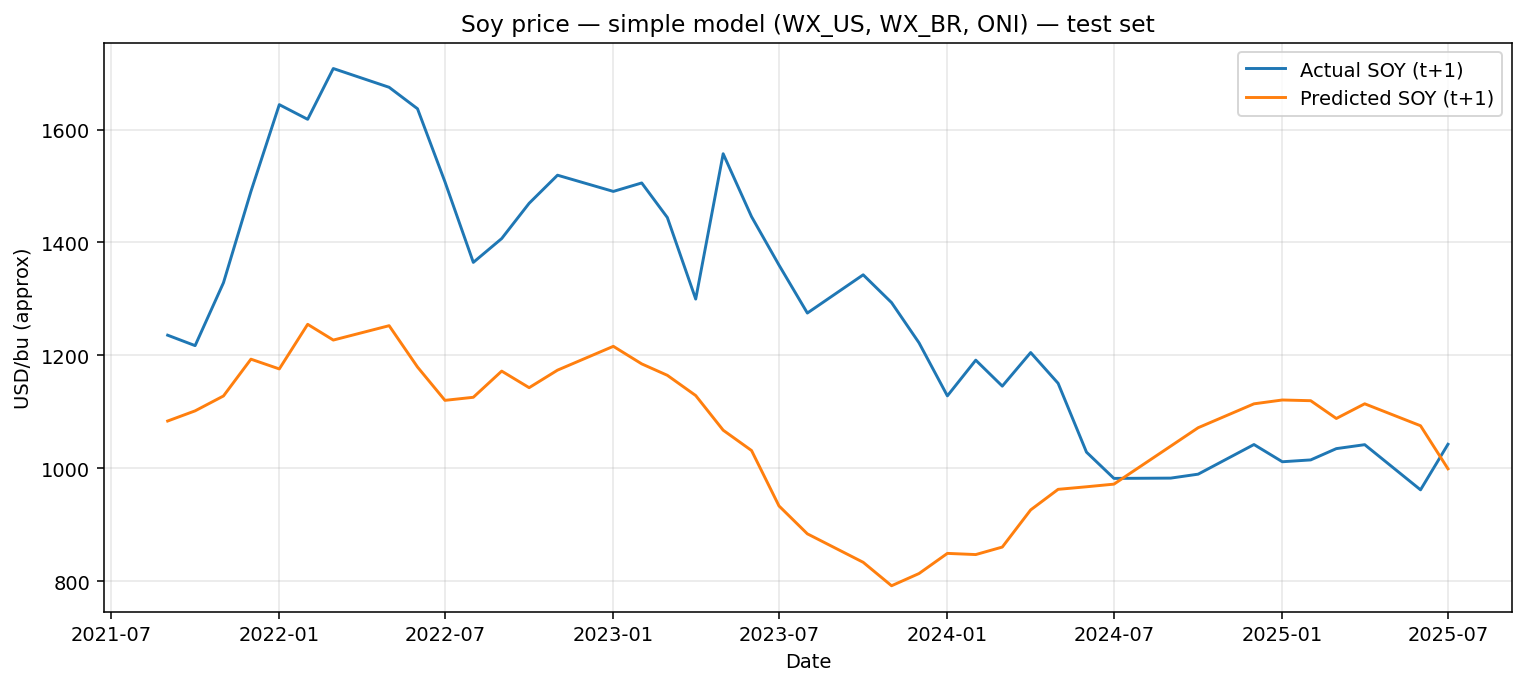

,coef_standardized
ONI_lag1,231.643535
WX_BR_lag1,12.056648
WX_US,7.787789
WX_BR_lag2,-2.748167
WX_US_lag2,-4.714482
WX_BR,-10.684367
WX_US_lag1,-29.951481
ONI,-167.606416
ONI_lag2,-173.717833


1078.7965838509317

In [5]:
# %% B) Wczytaj CSV → cechy, model, metryki, wykres

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

IN_CSV = os.path.join("data", "soy_simple_monthly.csv")
df = pd.read_csv(IN_CSV, parse_dates=["date"]).set_index("date").sort_index()

# 1) Cechy: minimalne lagi dla WX i ONI (1–2 mies.)
feature_base = ["WX_US", "WX_BR", "ONI"]
for c in feature_base:
    if c in df.columns:
        df[f"{c}_lag1"] = df[c].shift(1)
        df[f"{c}_lag2"] = df[c].shift(2)

# 2) Target: cena soi w następnym miesiącu (t+1)
df["SOY_t+1"] = df["SOY"].shift(-1)

# 3) Finalny dataset do ML (bez bieżącego SOY jako cechy)
feature_cols = [c for c in df.columns if c not in ["SOY", "SOY_t+1"]]
df_ml = df.dropna(subset=feature_cols + ["SOY_t+1"]).copy()

if len(df_ml) < 36:
    raise RuntimeError(
        f"Za mało obserwacji ({len(df_ml)}) do prostego modelu. "
        "Wydłuż historię (YEARS_BACK) lub ogranicz liczbę lagów."
    )

# 4) Split czasowy: ostatnie 20% → test
split_idx = int(len(df_ml) * 0.8)
train = df_ml.iloc[:split_idx]
test  = df_ml.iloc[split_idx:]

X_train = train[feature_cols]
y_train = train["SOY_t+1"]
X_test  = test[feature_cols]
y_test  = test["SOY_t+1"]

# 5) Pipeline: imputacja + standaryzacja + regresja liniowa
pre = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]), feature_cols)
])

model = Pipeline([
    ("pre", pre),
    ("lin", LinearRegression())
])

model.fit(X_train, y_train)

# 6) Ewaluacja
pred_train = model.predict(X_train)
pred_test  = model.predict(X_test)

def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))
def mape(a,b):
    a = np.array(a, dtype=float)
    b = np.array(b, dtype=float)
    m = a != 0
    return float(np.mean(np.abs((a[m]-b[m])/a[m]))*100)

metrics = {
    "train_MAE": float(np.mean(np.abs(y_train - pred_train))),
    "train_RMSE": rmse(y_train, pred_train),
    "train_MAPE_%": mape(y_train, pred_train),
    "test_MAE": float(np.mean(np.abs(y_test - pred_test))),
    "test_RMSE": rmse(y_test, pred_test),
    "test_MAPE_%": mape(y_test, pred_test),
}
print("METRYKI:", metrics)

# 7) Wykres: actual vs. predicted (test, target t+1)
plt.figure(figsize=(11,5))
plt.plot(y_test.index, y_test.values, label="Actual SOY (t+1)")
plt.plot(y_test.index, pred_test, label="Predicted SOY (t+1)")
plt.title("Soy price — simple model (WX_US, WX_BR, ONI) — test set")
plt.xlabel("Date"); plt.ylabel("USD/bu (approx)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.show()

# 8) Współczynniki (standaryzowane wejścia)
lin = model.named_steps["lin"]
coefs = pd.Series(lin.coef_, index=feature_cols).sort_values(ascending=False)
display(coefs.to_frame("coef_standardized"), lin.intercept_)
